<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/rl/berater-v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Berater Environment v5

## Changes from v3
  1. create a complete customer graph including costs of travel
  1. non existing connection has hightst penalty
  1. per episode set certain rewards to 0 to simulate different customers per consultant
  1. make sure things generalize well
   
## Links
1. Visualizing progress: https://github.com/openai/baselines/blob/master/docs/viz/viz.ipynb

## Installation (required for colab)

In [0]:
# !pip install git+https://github.com/openai/baselines >/dev/null
# !pip install gym >/dev/null

In [0]:
cnt=0

In [0]:
import numpy
import gym
from gym.utils import seeding
from gym import spaces

def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C'
    }
    return state_map[state_as_int]
    
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions: 
    There are 3 discrete deterministic actions:
    - 0: First Direction
    - 1: Second Direction
    - 2: Third Direction / Go home
    """
    metadata = {'render.modes': ['ansi']}
    
    showStep = False
    showDone = True
    envEpisodeModulo = 100

    def __init__(self):
        self.map = {
            'S': [('A', 100), ('B', 400), ('C', 200 )],
            'A': [('B', 250), ('C', 400), ('S', 100 )],
            'B': [('A', 250), ('C', 250), ('S', 400 )],
            'C': [('A', 400), ('B', 250), ('S', 200 )]
        }
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=numpy.array([0,-1000,-1000,-1000,-1000,-1000,-1000]),
                                             high=numpy.array([3,1000,1000,1000,1000,1000,1000]),
                                             dtype=numpy.float32)
        self.reward_range = (-1, 1)

        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.envReward = 0
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, actionArg):
        paths = self.map[self.state]
        action = actionArg
        destination, cost = paths[action]
        lastState = self.state
        lastObState = state_name_to_int(lastState)
        customerReward = self.customer_reward[destination]

        info = {"from": self.state, "to": destination}

        self.state = destination
        reward = (-cost + self.customer_reward[destination]) / self.optimum
        self.customer_visited(destination)
        done = destination == 'S' and self.all_customers_visited()

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += reward
        self.stepCount += 1
        self.envReward += reward
        self.envStepCount += 1

        if self.showStep:
            print( "Episode: " + ("%4.0f  " % self.envEpisodeCount) + 
                   " Step: " + ("%4.0f  " % self.stepCount) + 
                   #lastState + ':' + str(lastObState) + ' --' + str(action) + '-> ' + self.state + ':' + str(stateAsInt) +
                   lastState + ' --' + str(action) + '-> ' + self.state + 
                   ' R=' + ("% 2.2f" % reward) + ' totalR=' + ("% 3.2f" % self.totalReward) + 
                   ' cost=' + ("%4.0f" % cost) + ' customerR=' + ("%4.0f" % customerReward) + ' optimum=' + ("%4.0f" % self.optimum)      
                   )

        if done and not self.isDone:
            self.envEpisodeCount += 1
            if BeraterEnv.showDone:
                episodes = BeraterEnv.envEpisodeModulo
                if (self.envEpisodeCount % BeraterEnv.envEpisodeModulo != 0):
                    episodes = self.envEpisodeCount % BeraterEnv.envEpisodeModulo
                print( "Done: " + 
                        ("episodes=%6.0f  " % self.envEpisodeCount) + 
                        ("avgSteps=%6.2f  " % (self.envStepCount/episodes)) + 
                        ("avgTotalReward=% 3.2f" % (self.envReward/episodes) )
                        )
                if (self.envEpisodeCount%BeraterEnv.envEpisodeModulo) == 0:
                    self.envReward = 0
                    self.envStepCount = 0

        self.isDone = done
        observation = self.getObservation(stateAsInt)

        return observation, reward, done, info

    def getObservation(self, position):
        result = numpy.array([ position, 
                               self.getEdgeObservation('S','A'),
                               self.getEdgeObservation('S','B'),
                               self.getEdgeObservation('S','C'),
                               self.getEdgeObservation('A','B'),
                               self.getEdgeObservation('A','C'),
                               self.getEdgeObservation('B','C'),
                              ],
                             dtype=numpy.float32)
        return result

    def getEdgeObservation(self, source, target):
        reward = self.customer_reward[target] 
        cost = self.getCost(source,target)
        result = reward - cost

        return result

    def getCost(self, source, target):
        paths = self.map[source]
        targetIndex=state_name_to_int(target)
        for destination, cost in paths:
            if destination == target:
                result = cost
                break

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        reward_per_customer = 1000
        self.customer_reward = {
            'S': 0,
            'A': reward_per_customer,
            'B': reward_per_customer,
            'C': reward_per_customer,
        }

        self.state = 'S'
        return self.getObservation(state_name_to_int(self.state))

# Register Einvornment

In [4]:
from gym.envs.registration import register

cnt += 1
id = "Berater-v{}".format(cnt)
register(
    id=id,
    entry_point=BeraterEnv
)   

print(id)

Berater-v1


# Try out Environment

In [5]:
BeraterEnv.showStep = True
BeraterEnv.showDone = True

env = gym.make(id)
print(env)
observation = env.reset()
print(observation)

for t in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
print(observation)

<BeraterEnv<Berater-v1>>
[  0. 900. 600. 800. 750. 600. 750.]
Episode:    0   Step:    1  S --0-> A R= 0.30 totalR= 0.30 cost= 100 customerR=1000 optimum=3000
Episode:    0   Step:    2  A --1-> C R= 0.20 totalR= 0.50 cost= 400 customerR=1000 optimum=3000
Episode:    0   Step:    3  C --0-> A R=-0.13 totalR= 0.37 cost= 400 customerR=   0 optimum=3000
Episode:    0   Step:    4  A --1-> C R=-0.13 totalR= 0.23 cost= 400 customerR=   0 optimum=3000
Episode:    0   Step:    5  C --1-> B R= 0.25 totalR= 0.48 cost= 250 customerR=1000 optimum=3000
Episode:    0   Step:    6  B --2-> S R=-0.13 totalR= 0.35 cost= 400 customerR=   0 optimum=3000
Done: episodes=     1  avgSteps=  6.00  avgTotalReward= 0.35
Episode finished after 6 timesteps
[   0. -100. -400. -200. -250. -400. -250.]


# Train model

* 0.73 would be perfect total reward

In [0]:
!rm -r logs
!mkdir logs
!mkdir logs/berater

In [7]:
# https://github.com/openai/baselines/blob/master/baselines/deepq/experiments/train_pong.py
# log_dir = logger.get_dir()
log_dir = '/content/logs/berater/'

import gym
from baselines import deepq
from baselines import bench
from baselines import logger

from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from baselines.common.vec_env.vec_monitor import VecMonitor
from baselines.ppo2 import ppo2

BeraterEnv.showStep = False
BeraterEnv.showDone = False

env = gym.make(id)

wrapped_env = DummyVecEnv([lambda: gym.make(id)])
monitored_env = VecMonitor(wrapped_env, log_dir)
model = ppo2.learn(network='mlp', env=monitored_env, total_timesteps=50000)

# monitored_env = bench.Monitor(env, log_dir)
# https://en.wikipedia.org/wiki/Q-learning#Influence_of_variables
# %time model = deepq.learn(\
#         monitored_env,\
#         seed=42,\
#         network='mlp',\
#         lr=1e-3,\
#         gamma=0.99,\
#         total_timesteps=30000,\
#         buffer_size=50000,\
#         exploration_fraction=0.5,\
#         exploration_final_eps=0.02,\
#         print_freq=1000)

model.save('berater-ppo-v4.pkl')
monitored_env.close()

Logging to /tmp/openai-2018-12-30-16-35-35-223043
-------------------------------------
| approxkl           | 0.0016190251 |
| clipfrac           | 0.008178711  |
| eplenmean          | 8.38         |
| eprewmean          | 0.26333332   |
| explained_variance | -0.948       |
| fps                | 484          |
| nupdates           | 1            |
| policy_entropy     | 1.0971563    |
| policy_loss        | -0.007735405 |
| serial_timesteps   | 2048         |
| time_elapsed       | 4.23         |
| total_timesteps    | 2048         |
| value_loss         | 0.054406162  |
-------------------------------------
-------------------------------------
| approxkl           | 0.0028790352 |
| clipfrac           | 0.020141602  |
| eplenmean          | 4.81         |
| eprewmean          | 0.5993334    |
| explained_variance | 0.807        |
| fps                | 511          |
| nupdates           | 10           |
| policy_entropy     | 0.6492778    |
| policy_loss        | -0.024496907 |


### Visualizing Results

https://github.com/openai/baselines/blob/master/docs/viz/viz.ipynb

In [12]:
!ls -l $log_dir

total 236
-rw-r--r-- 1 root root 237825 Dec 30 16:37 monitor.csv


In [13]:
from baselines.common import plot_util as pu
results = pu.load_results(log_dir)

/usr/local/lib/python3.6/dist-packages/baselines/bench/monitor.py:164: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


In [0]:
import matplotlib.pyplot as plt
import numpy as np
r = results[0]
# plt.ylim(-1, 1)
# plt.plot(np.cumsum(r.monitor.l), r.monitor.r)

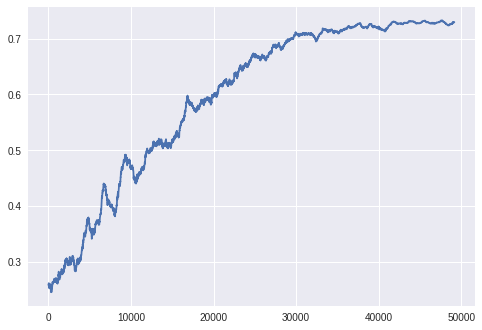

In [27]:
plt.plot(np.cumsum(r.monitor.l), pu.smooth(r.monitor.r, radius=100))

# Enjoy model

In [11]:
import numpy as np 

observation = env.reset()
state = np.zeros((1, 2*128))
dones = np.zeros((1))

BeraterEnv.showStep = True
BeraterEnv.showDone = False

for t in range(1000):
    actions, _, state, _ = model.step(observation, S=state, M=dones)
    observation, reward, done, info = env.step(actions[0])
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()

Episode:    0   Step:    1  S --0-> A R= 0.30 totalR= 0.30 cost= 100 customerR=1000 optimum=3000
Episode:    0   Step:    2  A --0-> B R= 0.25 totalR= 0.55 cost= 250 customerR=1000 optimum=3000
Episode:    0   Step:    3  B --1-> C R= 0.25 totalR= 0.80 cost= 250 customerR=1000 optimum=3000
Episode:    0   Step:    4  C --2-> S R=-0.07 totalR= 0.73 cost= 200 customerR=   0 optimum=3000
Episode finished after 4 timesteps
